In [1]:
import numpy as np 
import pandas as pd 
import os
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt 
import transformers
import random
import chardet
import warnings
warnings.simplefilter('ignore')
scaler = torch.cuda.amp.GradScaler() 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

/opt/homebrew/Caskroom/miniforge/base/envs/cq1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cpu')

In [2]:
def random_seed(SEED):
    
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    
SEED = 508
random_seed(SEED)

In [3]:
data = pd.read_csv('./phish_full.csv', nrows=1000)
data = data[['url','type']]
data = data.dropna()
display(data)
data.columns = ['url','type']
class_names = sorted(data['type'].unique().tolist())
print(class_names)
N = list(range(len(class_names)))
normal_mapping = dict(zip(class_names,N)) 
reverse_mapping = dict(zip(N,class_names))       
data['type'] = data['type'].map(normal_mapping) 

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
995,youtube.com/watch?v=EcGsM-PNQHQ,benign
996,bloomberg.com/news/2011-08-28/dust-bowl-in-tex...,benign
997,http://www.slavia.sk/home,defacement
998,innerearbrigade.com/,benign


['benign', 'defacement', 'malware', 'phishing']


In [4]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2, random_state=42)
model = transformers.RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=1)
#tokenizer = transformers.BertTokenizer.from_pretrained("../input/bert-base-uncased")
tokenizer = transformers.RobertaTokenizer.from_pretrained("roberta-base")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
test_s = train['url'].iloc[0]
result1 = tokenizer.encode_plus(test_s)
tokenizer.decode(result1["input_ids"])
result2 = tokenizer.encode_plus(
    test_s,
    add_special_tokens = True, 
    max_length = 32, 
    pad_to_max_length = True, 
    truncation = True 
)
tokenizer.decode(result2["input_ids"])

'<s>en.wikipedia.org/wiki/North_Dakota</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'

In [6]:
max_sens = 32
train = train.sort_values("type").reset_index(drop=True)
train["kfold"] = train.index % 5

p_train = train[train["kfold"] != 0].reset_index(drop=True)
p_valid = train[train["kfold"] == 0].reset_index(drop=True)
p_test = test.reset_index(drop=True)


In [7]:
class BERTDataSet(Dataset):
    
    def __init__(self,sentences,targets):        
        self.sentences = sentences
        self.targets = targets
        
    def __len__(self):        
        return len(self.sentences)
    
    def __getitem__(self,idx):        
        sentence = self.sentences[idx]    
        bert_sens = tokenizer.encode_plus(
                                sentence,
                                add_special_tokens = True, 
                                max_length = max_sens, 
                                pad_to_max_length = True, 
                                return_attention_mask = True)

        ids = torch.tensor(bert_sens['input_ids'], dtype=torch.long)
        mask = torch.tensor(bert_sens['attention_mask'], dtype=torch.long)

        target = torch.tensor(self.targets[idx],dtype=torch.float)
        
        return {
                'ids': ids,
                'mask': mask,

                'targets': target
            }

In [8]:
train_dataset = BERTDataSet(p_train["url"], p_train["type"])
valid_dataset = BERTDataSet(p_valid["url"], p_valid["type"])
test_dataset = BERTDataSet(p_test["url"], p_test["type"])

train_batch = 16
valid_batch = 32
test_batch = 32

train_dataloader = DataLoader(train_dataset, batch_size=train_batch, shuffle = True)
valid_dataloader = DataLoader(valid_dataset, batch_size=valid_batch, shuffle = False)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch, shuffle = False)

In [19]:
model.to(device)
model.train()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [20]:
for a in train_dataloader:
    ids = a["ids"].to(device)
    mask = a["mask"].to(device)
    output = model(ids,mask)
    break

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [21]:
output = output["logits"].squeeze(-1).shape
from transformers import AdamW
LR=2e-5
optimizer = AdamW(model.parameters(), LR,betas=(0.9, 0.999), weight_decay=1e-2)

In [23]:
debug = False
debug2 = False

In [24]:
from transformers import get_linear_schedule_with_warmup
epochs = 10
if debug:
    epochs = 1
train_steps = int(len(p_train)/train_batch*epochs)
print(train_steps)
num_steps = int(train_steps*0.1)
scheduler = get_linear_schedule_with_warmup(optimizer, num_steps, train_steps)
def loss_fn(output,target):
    return torch.sqrt(nn.MSELoss()(output,target))

400


In [26]:
def training(
    train_dataloader,
    model,
    optimizer,
    scheduler
):
    
    model.train()
    torch.backends.cudnn.benchmark = True
    allpreds = []
    alltargets = []

    for a in train_dataloader:

        losses = []
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():

            ids = a["ids"].to(device,non_blocking=True)
            mask = a["mask"].to(device,non_blocking=True)

            output = model(ids,mask)
            output = output["logits"].squeeze(-1)
            target = a["targets"].to(device,non_blocking=True)
            loss = loss_fn(output,target)

            losses.append(loss.item())
            allpreds.append(output.detach().cpu().numpy())
            alltargets.append(target.detach().squeeze(-1).cpu().numpy())

        scaler.scale(loss).backward() 
        scaler.step(optimizer) 
        scaler.update() 
        
        del loss 

        scheduler.step() 

    allpreds = np.concatenate(allpreds)
    alltargets = np.concatenate(alltargets)
    losses = np.mean(losses)
    train_rme_loss = np.sqrt(mean_squared_error(alltargets,allpreds))

    return losses,train_rme_loss

In [28]:
def validating(valid_dataloader,model):
    
    model.eval()
    allpreds = []
    alltargets = []

    for a in valid_dataloader:
        losses = []
        with torch.no_grad():

            ids = a["ids"].to(device)
            mask = a["mask"].to(device)

            output = model(ids,mask)
            output = output["logits"].squeeze(-1)
            target = a["targets"].to(device)
            loss = loss_fn(output,target)
            losses.append(loss.item())
            allpreds.append(output.detach().cpu().numpy())
            alltargets.append(target.detach().squeeze(-1).cpu().numpy())
            
            del loss

    allpreds = np.concatenate(allpreds)
    alltargets = np.concatenate(alltargets)
    losses = np.mean(losses)
    valid_rme_loss = np.sqrt(mean_squared_error(alltargets,allpreds))

    return allpreds,losses,valid_rme_loss

In [29]:
if debug2 == False:
    for a in range(epochs):
        for b in train_dataloader:
            break
    losses, train_rme_loss = training(train_dataloader,model,optimizer,scheduler)
    for a in valid_dataloader:
        break

In [30]:
trainlosses = []
vallosses = []
bestscore = None
trainscores = []
validscores = []

for epoch in tqdm(range(epochs)):
    
    print("---------------" + str(epoch) + "start-------------")
    
    trainloss,trainscore = training(train_dataloader,model,optimizer,scheduler)    
    trainlosses.append(trainloss)
    trainscores.append(trainscore)
    
    print("trainscore is " + str(trainscore))
    
    preds,validloss,valscore=validating(valid_dataloader,model)    
    vallosses.append(validloss)
    validscores.append(valscore)
    
    print("valscore is " + str(valscore))
    
    if bestscore is None:
        bestscore = valscore
        
        print("Save first model")
        
        state = {
                        'state_dict': model.state_dict(),
                        'optimizer_dict': optimizer.state_dict(),
                        "bestscore":bestscore
                    }
            
        torch.save(state, "model0.pth")
        
    elif bestscore > valscore:
        
        bestscore = valscore        
        print("found better point")        
        state = {
                        'state_dict': model.state_dict(),
                        'optimizer_dict': optimizer.state_dict(),
                        "bestscore":bestscore
                    }
            
        torch.save(state, "model0.pth")
        
    else:
        pass

  0%|          | 0/10 [00:00<?, ?it/s]

---------------0start-------------
trainscore is 0.54430896
valscore is 0.31430078
Save first model


 10%|█         | 1/10 [01:48<16:15, 108.43s/it]

---------------1start-------------
trainscore is 0.3448117
valscore is 0.27839538
found better point


 20%|██        | 2/10 [03:34<14:17, 107.23s/it]

---------------2start-------------
trainscore is 0.30663714
valscore is 0.25402513
found better point


 30%|███       | 3/10 [05:07<11:43, 100.47s/it]

---------------3start-------------
trainscore is 0.27798513
valscore is 0.20618749
found better point


 40%|████      | 4/10 [06:44<09:55, 99.20s/it] 

---------------4start-------------
trainscore is 0.21812029


 50%|█████     | 5/10 [08:17<08:04, 96.94s/it]

valscore is 0.23377347
---------------5start-------------
trainscore is 0.20469613


 60%|██████    | 6/10 [09:48<06:19, 94.86s/it]

valscore is 0.20981279
---------------6start-------------
trainscore is 0.18354738
valscore is 0.18053117
found better point


 70%|███████   | 7/10 [11:23<04:45, 95.09s/it]

---------------7start-------------
trainscore is 0.16641673


 80%|████████  | 8/10 [12:53<03:06, 93.27s/it]

valscore is 0.19842905
---------------8start-------------
trainscore is 0.14096199


 90%|█████████ | 9/10 [14:21<01:31, 91.63s/it]

valscore is 0.20244704
---------------9start-------------
trainscore is 0.15528801


100%|██████████| 10/10 [16:06<00:00, 96.62s/it]

valscore is 0.20244704


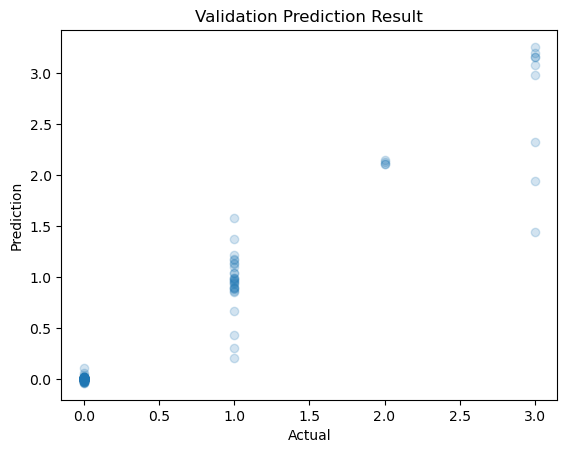

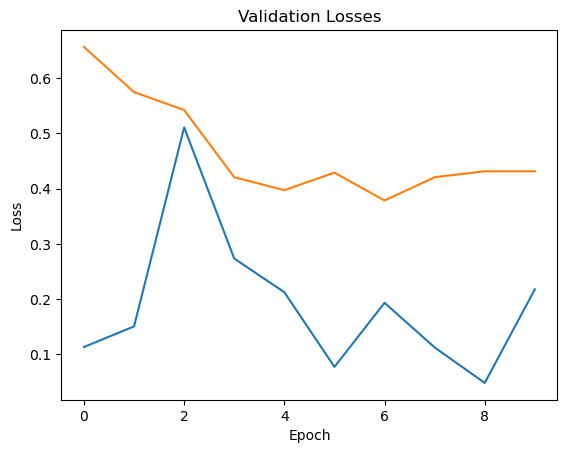

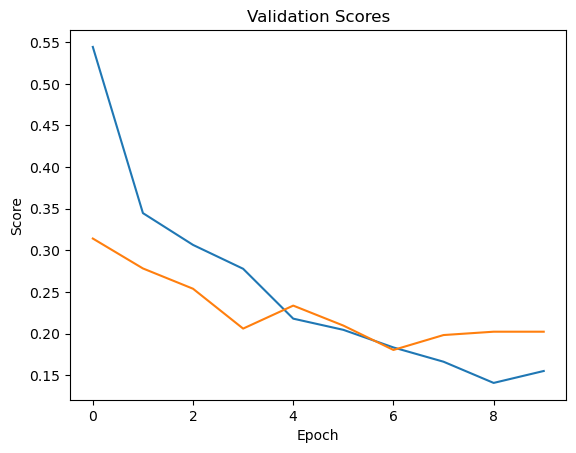

In [32]:
plt.scatter(p_valid['type'],preds, alpha=0.2)
plt.title('Validation Prediction Result')
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.show()

x = np.arange(epochs)
plt.title('Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(x,trainlosses)
plt.plot(x,vallosses)
plt.show()

x = np.arange(epochs)
plt.title('Validation Scores')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.plot(x,trainscores)
plt.plot(x,validscores)
plt.show()

In [33]:
val_true = p_valid['type']
val_pred = []
for p in preds:
    val_pred+=[round(p,0)]

from sklearn.metrics import classification_report
print(classification_report(val_true,val_pred,target_names=class_names,digits=4))

              precision    recall  f1-score   support

      benign     0.9754    1.0000    0.9876       119
  defacement     0.9600    0.8571    0.9057        28
     malware     0.5714    1.0000    0.7273         4
    phishing     1.0000    0.6667    0.8000         9

    accuracy                         0.9563       160
   macro avg     0.8767    0.8810    0.8551       160
weighted avg     0.9640    0.9563    0.9562       160



In [35]:
bestscores = []
bestscores.append(bestscore)

for fold in range(1,5):
    
    # initializing the data
    p_train = train[train["kfold"]!=fold].reset_index(drop=True)
    p_valid = train[train["kfold"]==fold].reset_index(drop=True)

    train_dataset = BERTDataSet(p_train["url"],p_train["type"])
    valid_dataset = BERTDataSet(p_valid["url"],p_valid["type"])

    train_dataloader = DataLoader(train_dataset,batch_size=train_batch,shuffle = True)
    valid_dataloader = DataLoader(valid_dataset,batch_size=valid_batch,shuffle = False)

    model = transformers.RobertaForSequenceClassification.from_pretrained("roberta-base",num_labels=1)

    model.to(device)
    LR=2e-5
    optimizer = AdamW(model.parameters(), LR,betas=(0.9, 0.999), weight_decay=1e-2) # AdamW optimizer
    train_steps = int(len(p_train)/train_batch*epochs)
    num_steps = int(train_steps*0.1)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_steps, train_steps)

    trainlosses = []
    vallosses = []
    bestscore = None
    trainscores = []
    validscores = []

    for epoch in tqdm(range(epochs)):

        print("---------------" + str(epoch) + "start-------------")

        trainloss,trainscore = training(train_dataloader,model,optimizer,scheduler)
        trainlosses.append(trainloss)
        trainscores.append(trainscore)

        print("trainscore is " + str(trainscore))

        preds,validloss,valscore=validating(valid_dataloader,model)
        vallosses.append(validloss)
        validscores.append(valscore)

        print("valscore is " + str(valscore))

        if bestscore is None:
            bestscore = valscore

            print("Save first model")

            state = {
                            'state_dict': model.state_dict(),
                            'optimizer_dict': optimizer.state_dict(),
                            "bestscore":bestscore
                        }

            torch.save(state, "model" + str(fold) + ".pth") 

        elif bestscore > valscore:
            bestscore = valscore
            print("found better point")

            state = {
                            'state_dict': model.state_dict(),
                            'optimizer_dict': optimizer.state_dict(),
                            "bestscore":bestscore
                        }
            torch.save(state, "model"+ str(fold) + ".pth")

        else:
            pass


    bestscores.append(bestscore)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should pr

---------------0start-------------
trainscore is 0.82499206
valscore is 0.7633108
Save first model


 10%|█         | 1/10 [01:40<15:08, 100.97s/it]

---------------1start-------------
trainscore is 0.69271463
valscore is 0.5736636
found better point


 20%|██        | 2/10 [03:29<14:01, 105.24s/it]

---------------2start-------------
trainscore is 0.48457068
valscore is 0.39660144
found better point


 30%|███       | 3/10 [05:10<12:04, 103.52s/it]

---------------3start-------------
trainscore is 0.30477443
valscore is 0.33348966
found better point


 40%|████      | 4/10 [06:59<10:32, 105.48s/it]

---------------4start-------------
trainscore is 0.29567468
valscore is 0.30053797
found better point


 50%|█████     | 5/10 [08:48<08:54, 106.83s/it]

---------------5start-------------
trainscore is 0.20948286


 60%|██████    | 6/10 [10:30<07:00, 105.13s/it]

valscore is 0.30580345
---------------6start-------------
trainscore is 0.19037317
valscore is 0.28846824
found better point


 70%|███████   | 7/10 [12:02<05:03, 101.00s/it]

---------------7start-------------
trainscore is 0.17137048
valscore is 0.28261995
found better point


 80%|████████  | 8/10 [13:32<03:14, 97.40s/it] 

---------------8start-------------
trainscore is 0.17093444
valscore is 0.27477992
found better point


 90%|█████████ | 9/10 [15:12<01:38, 98.38s/it]

---------------9start-------------
trainscore is 0.11508268
valscore is 0.27308133
found better point


100%|██████████| 10/10 [16:46<00:00, 100.63s/it]
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_pro

---------------0start-------------
trainscore is 0.8298632
valscore is 0.70670855
Save first model


 10%|█         | 1/10 [01:29<13:27, 89.73s/it]

---------------1start-------------
trainscore is 0.69196326
valscore is 0.52057993
found better point


 20%|██        | 2/10 [02:59<11:58, 89.77s/it]

---------------2start-------------
trainscore is 0.46661118
valscore is 0.37486878
found better point


 30%|███       | 3/10 [04:35<10:48, 92.69s/it]

---------------3start-------------
trainscore is 0.35285258
valscore is 0.3444834
found better point


 40%|████      | 4/10 [06:01<08:59, 89.94s/it]

---------------4start-------------
trainscore is 0.27375096
valscore is 0.3350683
found better point


 50%|█████     | 5/10 [07:22<07:13, 86.74s/it]

---------------5start-------------
trainscore is 0.24696653
valscore is 0.31466335
found better point


 60%|██████    | 6/10 [08:56<05:56, 89.13s/it]

---------------6start-------------
trainscore is 0.22317739
valscore is 0.3020527
found better point


 70%|███████   | 7/10 [10:22<04:24, 88.29s/it]

---------------7start-------------
trainscore is 0.17492056
valscore is 0.3015336
found better point


 80%|████████  | 8/10 [11:56<02:59, 89.89s/it]

---------------8start-------------
trainscore is 0.15470618
valscore is 0.28620547
found better point


 90%|█████████ | 9/10 [13:29<01:31, 91.07s/it]

---------------9start-------------
trainscore is 0.13740158
valscore is 0.28485638
found better point


100%|██████████| 10/10 [15:03<00:00, 90.35s/it]
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj

---------------0start-------------
trainscore is 0.82337433
valscore is 0.70907027
Save first model


 10%|█         | 1/10 [01:40<15:02, 100.31s/it]

---------------1start-------------
trainscore is 0.6980228
valscore is 0.68541396
found better point


 20%|██        | 2/10 [03:11<12:37, 94.68s/it] 

---------------2start-------------
trainscore is 0.58358634
valscore is 0.2921658
found better point


 30%|███       | 3/10 [04:39<10:41, 91.61s/it]

---------------3start-------------
trainscore is 0.39315584
valscore is 0.26276168
found better point


 40%|████      | 4/10 [06:04<08:55, 89.27s/it]

---------------4start-------------
trainscore is 0.32646292
valscore is 0.24805172
found better point


 50%|█████     | 5/10 [07:40<07:37, 91.51s/it]

---------------5start-------------
trainscore is 0.28551382


 60%|██████    | 6/10 [09:15<06:11, 92.98s/it]

valscore is 0.28919527
---------------6start-------------
trainscore is 0.2893442


 70%|███████   | 7/10 [10:44<04:34, 91.58s/it]

valscore is 0.4385648
---------------7start-------------
trainscore is 0.19591463


 80%|████████  | 8/10 [12:22<03:07, 93.53s/it]

valscore is 0.29059082
---------------8start-------------
trainscore is 0.17910743
valscore is 0.23475021
found better point


 90%|█████████ | 9/10 [13:51<01:32, 92.13s/it]

---------------9start-------------
trainscore is 0.15425953
valscore is 0.22612706
found better point


100%|██████████| 10/10 [15:21<00:00, 92.11s/it]
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj

---------------0start-------------
trainscore is 0.85766184
valscore is 0.7200919
Save first model


 10%|█         | 1/10 [01:28<13:18, 88.77s/it]

---------------1start-------------
trainscore is 0.6485325
valscore is 0.46801534
found better point


 20%|██        | 2/10 [02:52<11:26, 85.83s/it]

---------------2start-------------
trainscore is 0.39535686


 30%|███       | 3/10 [04:21<10:09, 87.04s/it]

valscore is 0.48011592
---------------3start-------------
trainscore is 0.3200572
valscore is 0.38054964
found better point


 40%|████      | 4/10 [05:55<08:59, 89.89s/it]

---------------4start-------------
trainscore is 0.26935476


 50%|█████     | 5/10 [07:31<07:40, 92.20s/it]

valscore is 0.38058424
---------------5start-------------
trainscore is 0.23028608


 60%|██████    | 6/10 [08:57<06:00, 90.05s/it]

valscore is 0.38467523
---------------6start-------------
trainscore is 0.1930601


 70%|███████   | 7/10 [10:18<04:21, 87.15s/it]

valscore is 0.3961535
---------------7start-------------
trainscore is 0.14717884


 80%|████████  | 8/10 [11:45<02:54, 87.17s/it]

valscore is 0.39194283
---------------8start-------------
trainscore is 0.1370722


 90%|█████████ | 9/10 [13:25<01:30, 90.96s/it]

valscore is 0.3867791
---------------9start-------------
trainscore is 0.12177423


100%|██████████| 10/10 [15:04<00:00, 90.42s/it]

valscore is 0.38961482


In [36]:
bestscores

[0.18053117, 0.27308133, 0.28485638, 0.22612706, 0.38054964]

In [37]:
np.mean(bestscores)
print("my cv is " + str(np.mean(bestscores)))

my cv is 0.2690291


In [38]:
def predicting(test_dataloader,model):
    
    model.to(device)
    model.eval()   
    allpreds = []
    preds = []
    allvalloss=0

    with torch.no_grad():
        for a in test_dataloader:

            ids = a["ids"].to(device)
            mask = a["mask"].to(device)

            output = model(ids,mask)
            output = output["logits"].squeeze(-1)
            preds.append(output.cpu().numpy())

        preds = np.concatenate(preds)
        allpreds.append(preds)

    return allpreds

tpreds = predicting(test_dataloader,model)

In [39]:
#model initialized
model = transformers.RobertaForSequenceClassification.from_pretrained("roberta-base",num_labels=1)

pthes = [os.path.join("./",s) for s in os.listdir("./") if ".pth" in s]

def predicting2(
    test_dataloader,
    model,
    pthes 
):

    allpreds = []    
    for pth in pthes:
        
        state = torch.load(pth)        
        model.load_state_dict(state["state_dict"])
        model.to(device)
        model.eval()      
        preds = []
        allvalloss=0

        with torch.no_grad():

            for a in test_dataloader:

                ids = a["ids"].to(device)
                mask = a["mask"].to(device)

                output = model(ids,mask)
                output = output["logits"].squeeze(-1)
                preds.append(output.cpu().numpy())

            preds = np.concatenate(preds)           
            allpreds.append(preds)

    return allpreds

tpreds = predicting2(test_dataloader,model,pthes)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should pr

In [40]:
test_true = p_test['type']
test_pred = []
for p in tpreds[0]:
    test_pred+=[round(p,0)]

from sklearn.metrics import classification_report
print(classification_report(test_true,test_pred,target_names=class_names,digits=4))

              precision    recall  f1-score   support

      benign     0.9929    0.9929    0.9929       141
  defacement     0.9318    0.9535    0.9425        43
     malware     0.5000    0.5714    0.5333         7
    phishing     0.8571    0.6667    0.7500         9

    accuracy                         0.9550       200
   macro avg     0.8205    0.7961    0.8047       200
weighted avg     0.9564    0.9550    0.9551       200



In [ ]:
# load a BERT sentiment analysis model
tokenizer = transformers.DistilBertTokenizerFast.from_pretrained("roberta-base")
model = transformers.DistilBertForSequenceClassification.from_pretrained(
    "roberta-base"
).cuda()

# define a prediction function
def f(x):
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=500, truncation=True) for v in x]).cuda()
    outputs = model(tv)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores[:,1]) # use one vs rest logit units
    return val

# build an explainer using a token masker
explainer = shap.Explainer(f, tokenizer)

# explain the model's predictions on url reviews
shap_values = explainer(train[:30], fixed_context=1, batch_size=2)

In [38]:
import shap
import transformers
import torch
import numpy as np
import scipy as sp

# load a BERT sentiment analysis model
model = transformers.RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=1)
tokenizer = transformers.RobertaTokenizer.from_pretrained("roberta-base")

# define a prediction function
def f(x):
    # tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=500, truncation=True) for v in x])
    # outputs = model(tv)[0].detach().cpu().numpy()
    # scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    # val = sp.special.logit(scores[:,1]) # use one vs rest logit units
    # return val
    tv = tokenizer(x, truncation=True, padding=True, return_tensors='pt')
    outputs = model(**tv)
    return outputs.logits

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
newdata = data['url'].tolist()
newdata

['br-icloud.com.br',
 'mp3raid.com/music/krizz_kaliko.html',
 'bopsecrets.org/rexroth/cr/1.htm',
 'http://www.garage-pirenne.be/index.php?option=com_content&view=article&id=70&vsig70_0=15',
 'http://adventure-nicaragua.net/index.php?option=com_mailto&tmpl=component&link=aHR0cDovL2FkdmVudHVyZS1uaWNhcmFndWEubmV0L2luZGV4LnBocD9vcHRpb249Y29tX2NvbnRlbnQmdmlldz1hcnRpY2xlJmlkPTQ3OmFib3V0JmNhdGlkPTM2OmRlbW8tYXJ0aWNsZXMmSXRlbWlkPTU0',
 'http://buzzfil.net/m/show-art/ils-etaient-loin-de-s-imaginer-que-le-hibou-allait-faire-ceci-quand-ils-filmaient-2.html',
 'espn.go.com/nba/player/_/id/3457/brandon-rush',
 'yourbittorrent.com/?q=anthony-hamilton-soulife',
 'http://www.pashminaonline.com/pure-pashminas',
 'allmusic.com/album/crazy-from-the-heat-r16990',
 'corporationwiki.com/Ohio/Columbus/frank-s-benson-P3333917.aspx',
 'http://www.ikenmijnkunst.nl/index.php/exposities/exposities-2006',
 'myspace.com/video/vid/30602581',
 'http://www.lebensmittel-ueberwachung.de/index.php/aktuelles.1',
 'http://w

In [ ]:
explainer = shap.Explainer(f, tokenizer)
shap_values = explainer(newdata, fixed_context=1)

In [57]:
class model_Pred():
    def __init__(self, model, tokenizer, max_length=128):
        self.model = model
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def tokenfun(self, text):
        encoded_sent = self.tokenizer.encode_plus(
            text=text,  # Preprocess sentence
            add_special_tokens=True,  # Add `[CLS]` and `[SEP]`
            max_length=self.max_length,  # Max length to truncate/pad
            padding='max_length',  # Pad sentence to max length
            truncation=True,
            return_tensors='pt',  # Return PyTorch tensor
            return_attention_mask=True  # Return attention mask
        )

        input_ids = encoded_sent.get('input_ids')
        attention_masks = encoded_sent.get('attention_mask')
        return input_ids, attention_masks
        
    def get_proba_list(self,tlist):
        predlist = []
        for text in tlist:
            input_ids, attention_masks = self.tokenfun(text)
            with torch.no_grad():
                probs_detail = self.model(input_ids, attention_masks)
            prob = probs_detail[0].tolist()
            predlist.append(prob)
        return np.array(predlist)
    
    def get_pred_list(self,tlist):
        predlist = []
        for text in tlist:
            input_ids, attention_masks = self.tokenfun(text)
            with torch.no_grad():
                probs_detail = self.model(input_ids, attention_masks)
            prob = np.argmax(probs_detail[0].tolist())
            predlist.append(prob)
        return np.array(predlist)

text = "商务大床房，房间很大，床有2M宽，整体感觉经济实惠不错!"
mobj = model_Pred(model, tokenizer)
print(mobj.get_pred_list([text]))  # [1]
print(mobj.get_proba_list([text])) # [[2.76377570

[1]
[[[-0.44119495  0.00316086]]]


In [63]:
data = pd.read_csv('./phish_full.csv', nrows=1000)
data = data[['url','type']]
data = data.dropna()
# display(data)
data.columns = ['url','type']
data = data.replace('benign', 0)
data = data.replace('defacement', 1)
data = data.replace('phishing', 1)
data = data.replace('malware', 1)
data

,url,type
0,br-icloud.com.br,1
1,mp3raid.com/music/krizz_kaliko.html,0
2,bopsecrets.org/rexroth/cr/1.htm,0
3,http://www.garage-pirenne.be/index.php?option=...,1
4,http://adventure-nicaragua.net/index.php?optio...,1
...,...,...
995,youtube.com/watch?v=EcGsM-PNQHQ,0
996,bloomberg.com/news/2011-08-28/dust-bowl-in-tex...,0
997,http://www.slavia.sk/home,1
998,innerearbrigade.com/,0


In [68]:
import shap
explainer = shap.Explainer(mobj.get_pred_list, tokenizer)

In [70]:
shap_values = explainer(data.head(2)["url"])




















































































Partition explainer: 3it [03:30, 105.08s/it]


In [106]:
shap.plots.text(shap_values[0])
print(data['type'][0])

1


In [104]:
shap.plots.text(shap_values[1])
print(data['type'][1])

0


In [105]:
shap.plots.text(shap_values[2])
print(data['type'][2])

0


In [103]:
shap.plots.text(shap_values[3])
print(data['type'][3])

1


In [100]:
shap.plots.text(shap_values[4])
print(data['type'][4])

1


In [99]:
shap.plots.text(shap_values[5])
print(data['type'][5])

0


In [98]:
shap.plots.text(shap_values[6])
print(data['type'][6])

0


In [97]:
shap.plots.text(shap_values[7])
print(data['type'][7])

0


In [96]:
shap.plots.text(shap_values[8])
print(data['type'][8])

1


In [95]:
shap.plots.text(shap_values[9])
print(data['type'][9])


0


In [94]:
print(data.head(11))

                                                  url  type
0                                    br-icloud.com.br     1
1                 mp3raid.com/music/krizz_kaliko.html     0
2                     bopsecrets.org/rexroth/cr/1.htm     0
3   http://www.garage-pirenne.be/index.php?option=...     1
4   http://adventure-nicaragua.net/index.php?optio...     1
5   http://buzzfil.net/m/show-art/ils-etaient-loin...     0
6       espn.go.com/nba/player/_/id/3457/brandon-rush     0
7      yourbittorrent.com/?q=anthony-hamilton-soulife     0
8        http://www.pashminaonline.com/pure-pashminas     1
9       allmusic.com/album/crazy-from-the-heat-r16990     0
10  corporationwiki.com/Ohio/Columbus/frank-s-bens...     0


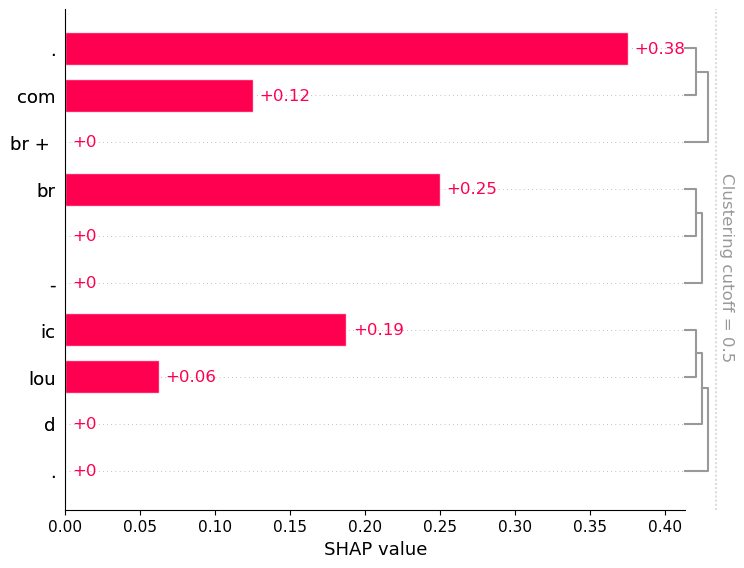

In [102]:
shap.plots.bar(shap_values[0,:,])

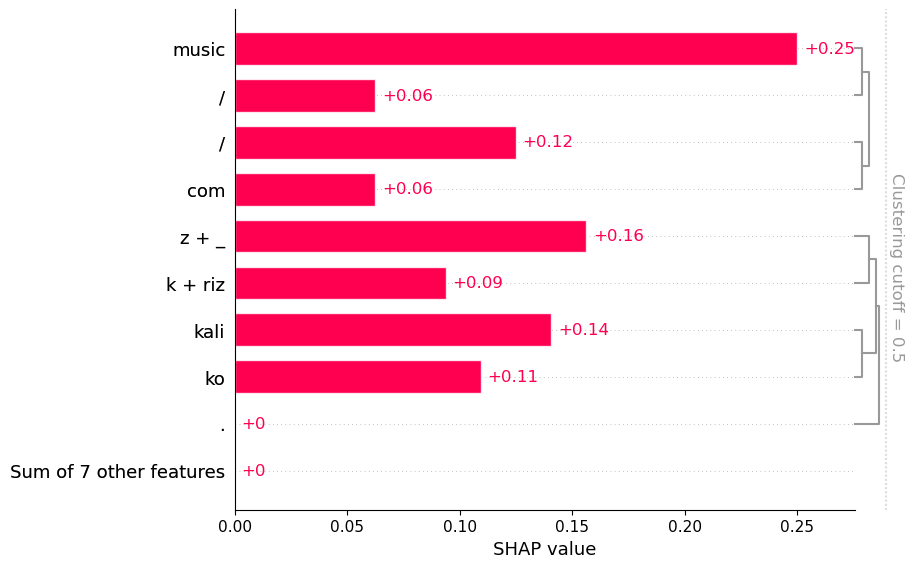

In [107]:
shap.plots.bar(shap_values[1,:,])

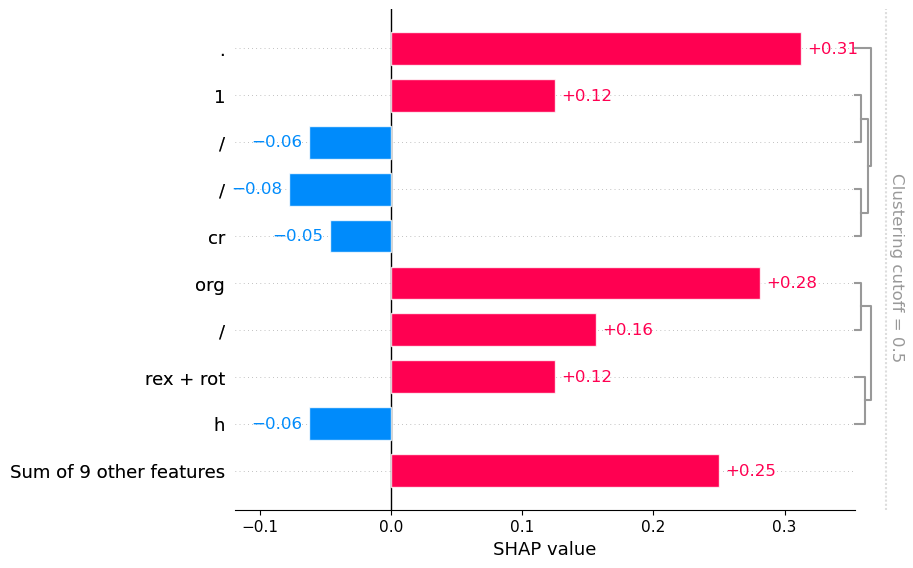

In [108]:
shap.plots.bar(shap_values[2,:,])

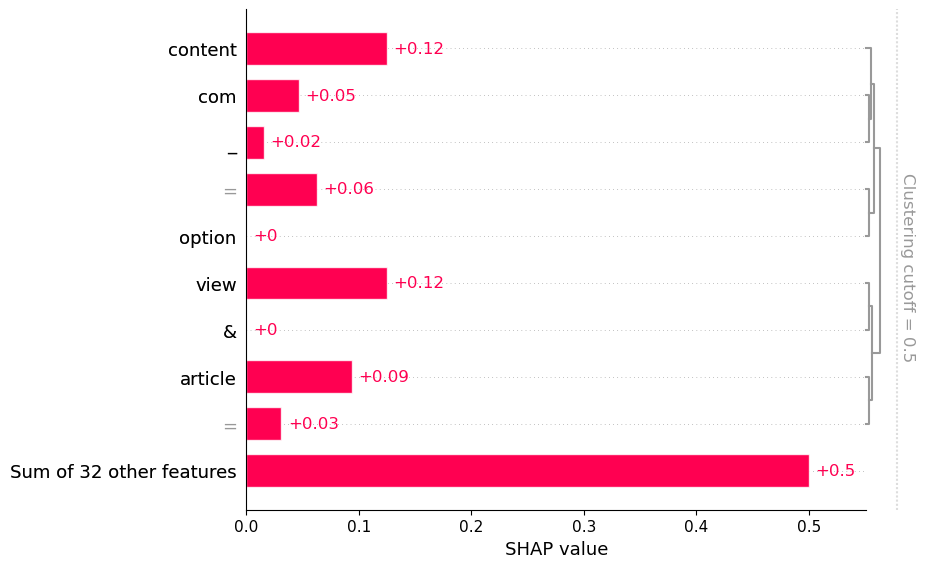

In [109]:
shap.plots.bar(shap_values[3,:,])

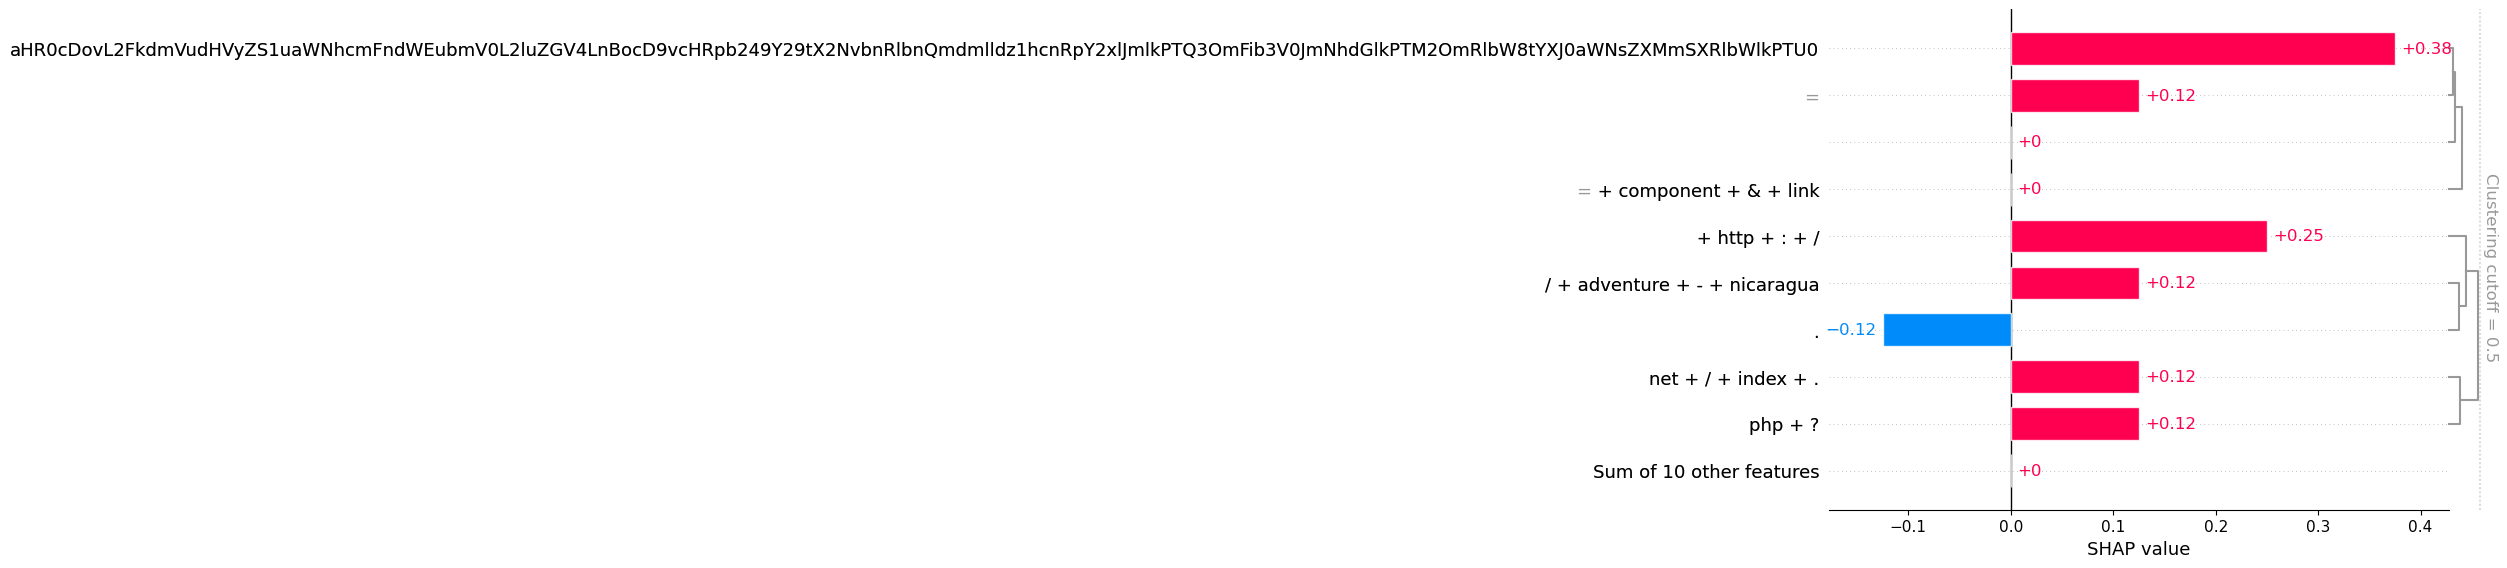

In [110]:
shap.plots.bar(shap_values[4,:,])

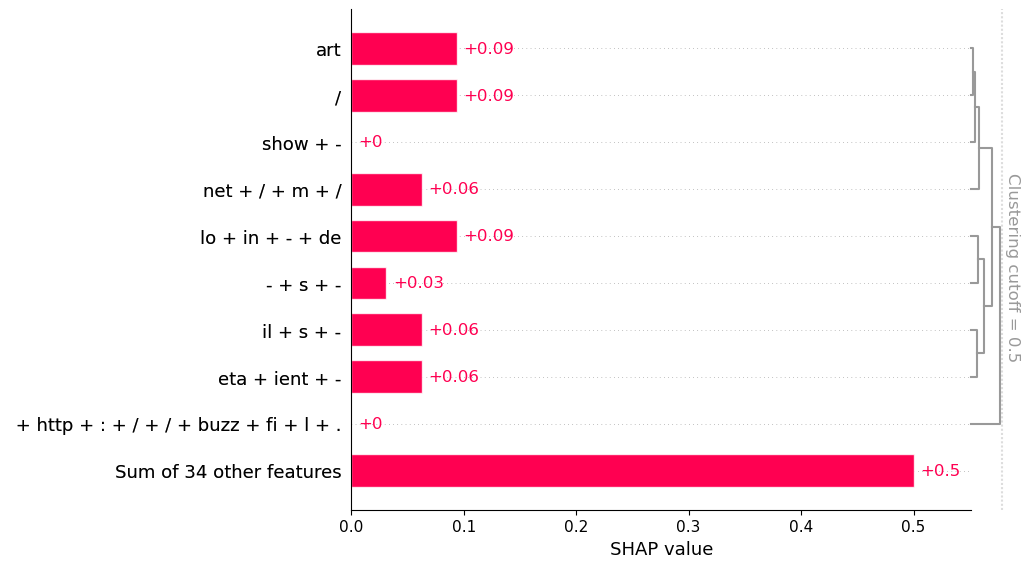

In [111]:
shap.plots.bar(shap_values[5,:,])

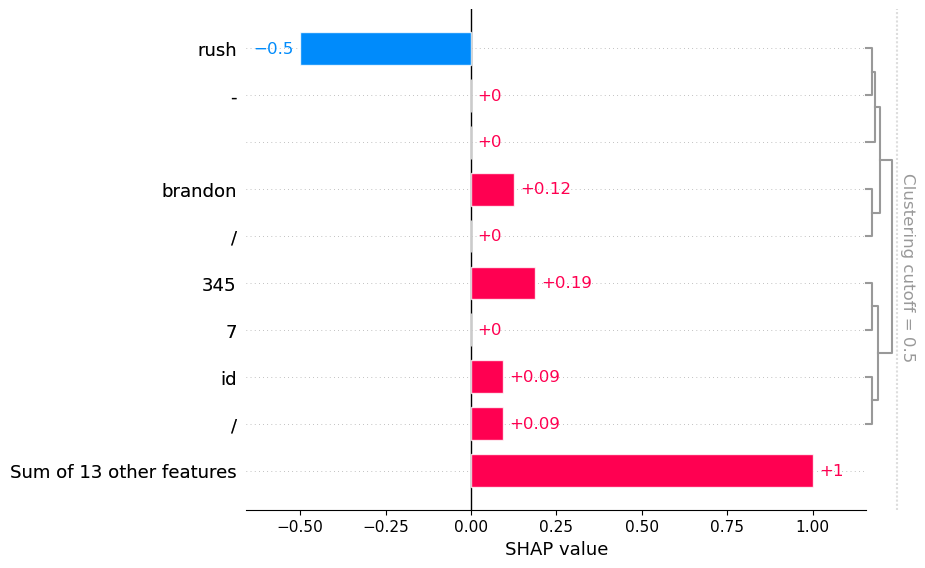

In [112]:
shap.plots.bar(shap_values[6,:,])

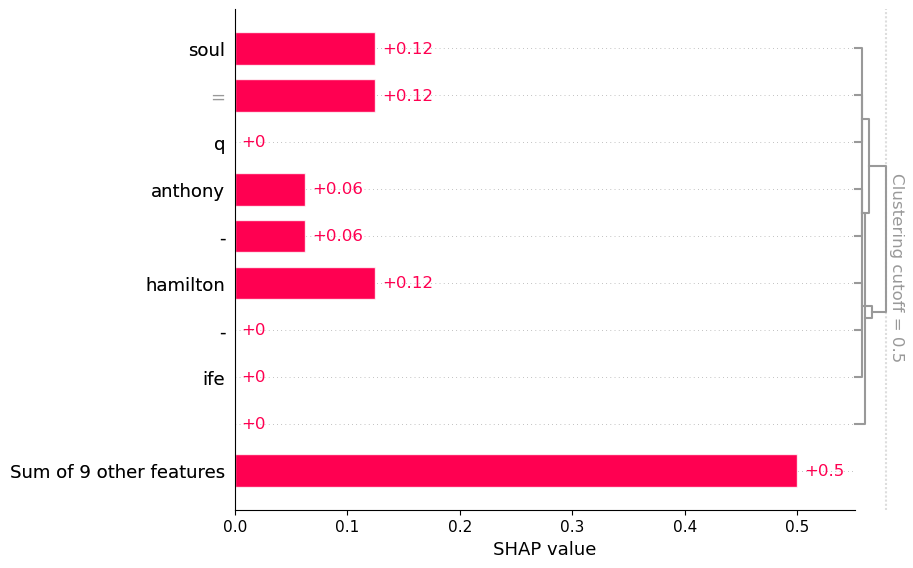

In [113]:
shap.plots.bar(shap_values[7,:,])

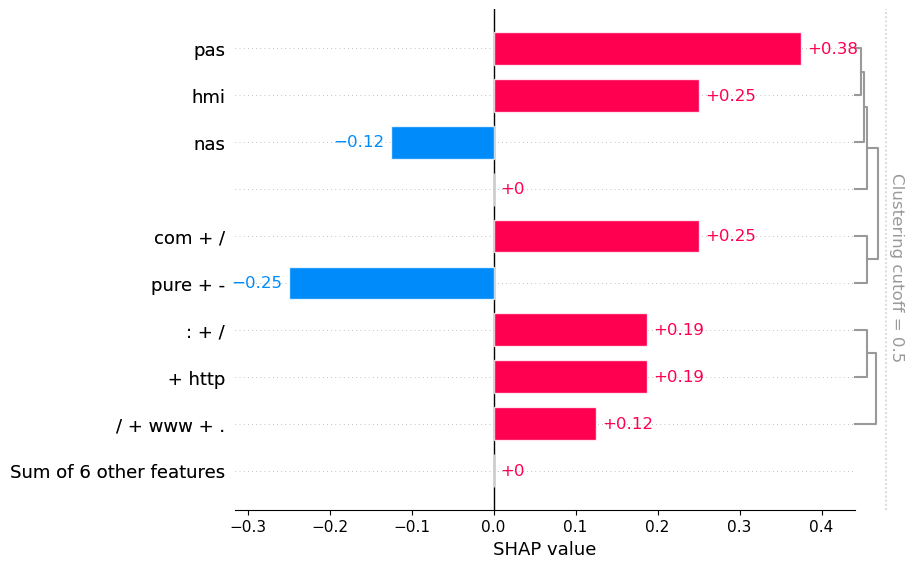

In [114]:
shap.plots.bar(shap_values[8,:,])

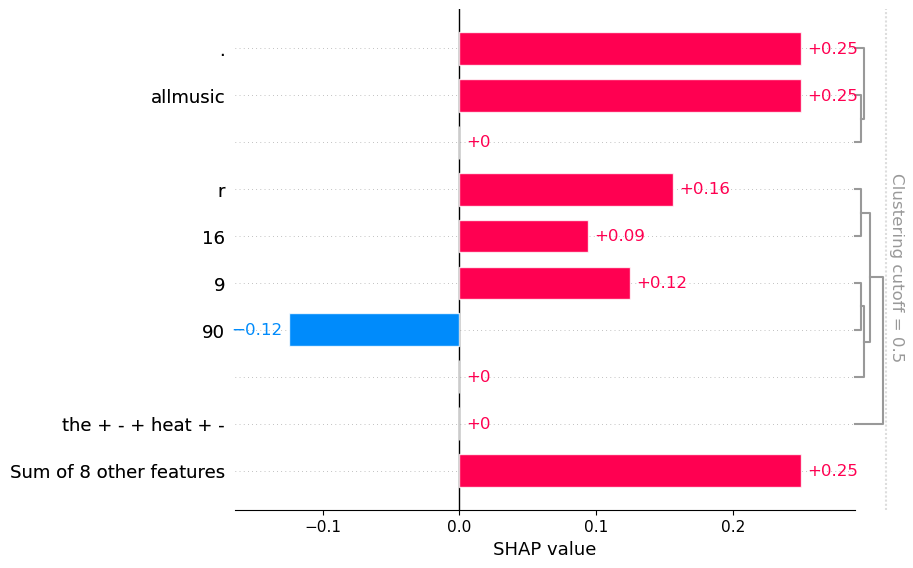

In [115]:
shap.plots.bar(shap_values[9,:,])

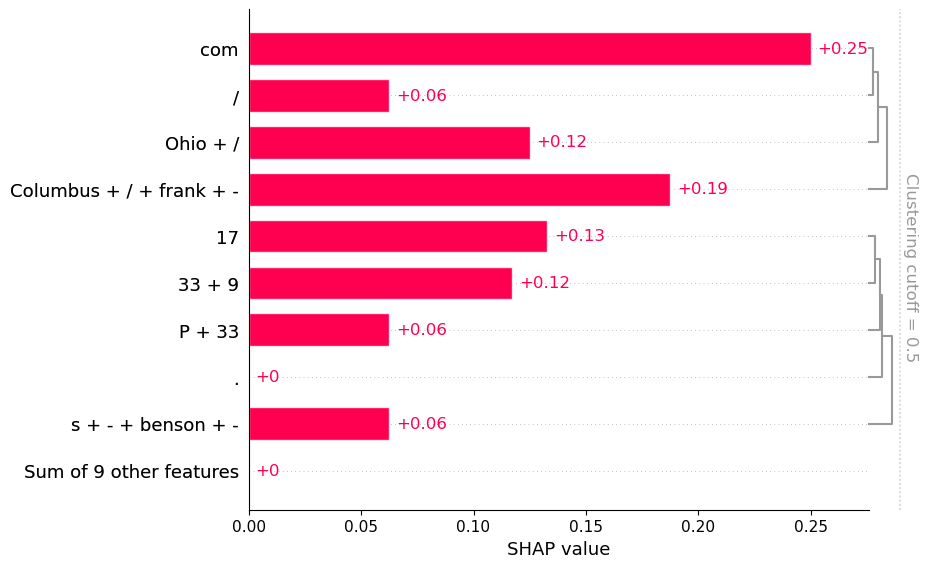

In [116]:
shap.plots.bar(shap_values[10,:,])